<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_codechallengedeepvsbreadth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [22]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [23]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


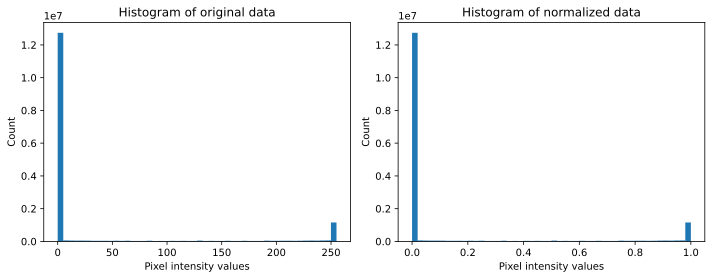

In [24]:
#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()
plt.show()

Create train/TEST GROUPS USING DataLoader

In [25]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [26]:
#check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTNet at 0x7872076c0f40>
data                     ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm                 ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT                    Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                      Figure           Figure(1000x400)
function2

Create the DL model

In [27]:
def createTheMNISTNet(nUnits,nlayers):
  class mnistNet(nn.Module):
      def __init__(self,nUnits,nlayers):
        super().__init__()
        #Create dictionar to store the layers
        self.layers=nn.ModuleDict()
        self.nLayers=nlayers
        ###Input layers
        self.layers['input']=nn.Linear(784,nUnits)
        ###Hidden layers
        for i in range(nlayers):
          self.layers[f'hidden{i}']=nn.Linear(nUnits,nUnits)
        ###output layers
        self.layers['output']=nn.Linear(nUnits,10)
      def forward(self,x):
         #input layers
          x=self.layers['input'](x)
          x=F.relu(x)
          #hidden layers
          for i in range(self.nLayers):
            x=self.layers[f'hidden{i}'](x)
            x=F.relu(x)
          #output layer
          x=self.layers['output'](x)
          return F.log_softmax(x,dim=1)

  # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet(nUnits,nlayers)
  #loss function
  lossfun = nn.NLLLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

In [28]:
#generate an instance of the model and inspect it
nUnitsperlayer=12
nLayers=4
net=createTheMNISTNet(nUnitsperlayer,nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Create a function that trains the model

In [30]:
# a function that trains the model
def function2trainTheModel(nUnits,nLayers):
  #number of epocs
  numepochs=60
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet(nUnits,nLayers)
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

In [32]:
#define the model parametes
numlayers=range(1,4)
numunits=np.arange(50,251,50)
#initialize output matrix
accuracies=np.zeros((2,len(numunits),len(numlayers)))
#start the experiment
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):
    trainAcc,testAcc,losses,net=function2trainTheModel(numunits[unitidx],numlayers[layeridx])
    #store the results(average of final 5 epochs)
    accuracies[0,unitidx,layeridx]=np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx]=np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


Run the model and show the results

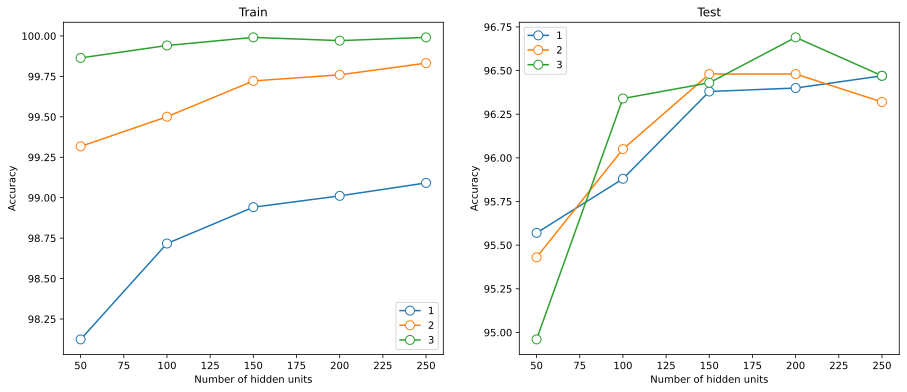

In [33]:

# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

Inspect the results in more detail